# AXA Coding Challenge
Author: Jonas Mickel

# Problem Statement

*Data Science Challenge
Data Innovation Lab, AXA Deutschland*

Der Fahrradverleih CitiBike (https://citibikenyc.com/) vermietet in New York über 12.000 Fahrräder an 750 Verleihstationen.
Somit ist CitiBike eine echte Alternative zu den herkömmlichen Transportmitteln, wie z.B. U-Bahn oder
Taxi. CitiBike stellt die durch den Verleih gesammelten Daten der Öffentlichkeit zur Verfügung
(s. bspw. „2023-citibike-tripdata.zip“).

Deine Aufgabe als Data Scientist ist es, CitiBike dabei zu helfen diese Daten wertstiftend zu nutzen,
beispielsweise indem du für CitiBike Kooperationsmöglichkeiten mit einer Versicherung (und/oder
umgekehrt) skizzierst. Dazu kannst du zusätzlich die öffentlich zugängigen Daten des NYPD zu
Verkehrsunfällen nutzen.

## Data Sources
- CitiBike Tripdata: https://s3.amazonaws.com/tripdata/index.html
    - subdivided in 3 types - all trip level data, i.e. each row = one trip start-station to end-station:
        - aggregated historical (e.g. YYYY-citibike-tripdata.zip)
        - running year monthly (e.g. 2024MM-citibike-tripdata(.csv).zip)
        - Jersey City monthly data (e.g. JC-YYYYMMM-citibike-tripdata.csv.zip)
- NYPD  Motor Vehicle Collision data: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data
    - Event log (each row = collision record)
### other possibly relevant data sources
- weather (https://open-meteo.com/en/docs/historical-weather-api#hourly=temperature_2m,is_day)
- traffic
- road conditions
- (NYPD Crime data: https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243/about_data)

## Potential ML solutions from insurance domain perspective
- Accident risk profiling of trips for personalized dynamic insurance pricing, which can be split into two problems:
    - (i) Predict likelihood of accident based on location, weather, traffic conditions
    - (ii) Predict the most likely target station for a rental, based on time, location, weather pattern
    - (i) + (ii) Derive the most likely route between start and target station, predict the accident likelihood for that route which in turn could be the basis for an accident insurance premium calculation

In [1]:
# Imports
from typing import List
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, f1_score)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import holidays
import joblib
import warnings

from citibike_utils import *

SEED = 2024

# Data loading and cleaning

In [2]:
accident_df = pl.scan_csv('data/Motor_Vehicle_Collisions_-_Crashes_20241201.csv')

In [3]:
accident_head = accident_df.head().collect()

In [4]:
accident_head

CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
str,str,str,i64,f64,f64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,i64,str,str,str,str,str
"""09/11/2021""","""2:39""",null,null,null,null,null,"""WHITESTONE EXPRESSWAY""","""20 AVENUE""",null,2,0,0,0,0,0,2,0,"""Aggressive Driving/Road Rage""","""Unspecified""",null,null,null,4455765,"""Sedan""","""Sedan""",null,null,null
"""03/26/2022""","""11:45""",null,null,null,null,null,"""QUEENSBORO BRIDGE UPPER""",null,null,1,0,0,0,0,0,1,0,"""Pavement Slippery""",null,null,null,null,4513547,"""Sedan""",null,null,null,null
"""06/29/2022""","""6:55""",null,null,null,null,null,"""THROGS NECK BRIDGE""",null,null,0,0,0,0,0,0,0,0,"""Following Too Closely""","""Unspecified""",null,null,null,4541903,"""Sedan""","""Pick-up Truck""",null,null,null
"""09/11/2021""","""9:35""","""BROOKLYN""",11208,40.667202,-73.8665,"""(40.667202, -73.8665)""",null,null,"""1211 LORING AVENUE""",0,0,0,0,0,0,0,0,"""Unspecified""",null,null,null,null,4456314,"""Sedan""",null,null,null,null
"""12/14/2021""","""8:13""","""BROOKLYN""",11233,40.683304,-73.917274,"""(40.683304, -73.917274)""","""SARATOGA AVENUE""","""DECATUR STREET""",null,0,0,0,0,0,0,0,0,null,null,null,null,null,4486609,null,null,null,null,null


In [5]:
accident_head.columns

['CRASH DATE',
 'CRASH TIME',
 'BOROUGH',
 'ZIP CODE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'ON STREET NAME',
 'CROSS STREET NAME',
 'OFF STREET NAME',
 'NUMBER OF PERSONS INJURED',
 'NUMBER OF PERSONS KILLED',
 'NUMBER OF PEDESTRIANS INJURED',
 'NUMBER OF PEDESTRIANS KILLED',
 'NUMBER OF CYCLIST INJURED',
 'NUMBER OF CYCLIST KILLED',
 'NUMBER OF MOTORIST INJURED',
 'NUMBER OF MOTORIST KILLED',
 'CONTRIBUTING FACTOR VEHICLE 1',
 'CONTRIBUTING FACTOR VEHICLE 2',
 'CONTRIBUTING FACTOR VEHICLE 3',
 'CONTRIBUTING FACTOR VEHICLE 4',
 'CONTRIBUTING FACTOR VEHICLE 5',
 'COLLISION_ID',
 'VEHICLE TYPE CODE 1',
 'VEHICLE TYPE CODE 2',
 'VEHICLE TYPE CODE 3',
 'VEHICLE TYPE CODE 4',
 'VEHICLE TYPE CODE 5']

### Filter out all cycling incidents
i.e. we are only interested in cases where there was at least one bike or e-bike participating

In [6]:
# check all used vehicle types
all_vehicle_types = set(accident_df.select([f'VEHICLE TYPE CODE {i+1}' for i in range(5)]).collect().to_pandas().values.flatten())
pd.Series(list(all_vehicle_types)).str.upper().drop_duplicates().sort_values().to_csv('./all_vehicle_types.csv')

In [7]:
# these were selected from manual inspection of the summarized file
relevant_vehicle_types = [
    "BICYC",
    "BICYCLE",
    "BIKE",
    "CITIBIKE",
    "E BIK",
    "E BIKE",
    "E BIKE UNI",
    "E BIKE W P",
    "E- BI",
    "E-BIK",
    "E-BIKE",
    "E/BIK",
    "EBIKE",
    "PEDAL BIKE",
    "UNI E-BIKE",
]

In [8]:
def clean_collision_data_by_vehicle(collision_data: pd.DataFrame, relevant_vehicle_types: List) -> pl.DataFrame:
    """
    Clean collision data to include only cycling-related collisions.
    """
    # Identify vehicle type columns
    vehicle_cols = [col for col in collision_data.columns if 'VEHICLE TYPE CODE' in col.upper()]
    
    # Create a boolean mask for collisions involving cyclists
    mask = collision_data[vehicle_cols].apply(lambda x: x.astype(str).str.upper()).isin(relevant_vehicle_types).any(axis=1)
    return collision_data.loc[mask,:]

In [9]:
bike_collision_df = clean_collision_data_by_vehicle(accident_df.collect().to_pandas(), relevant_vehicle_types)

In [10]:
bike_collision_df.shape

(80356, 29)

In [11]:
# keep only crashes with recorded locations and convert datetime
bike_collision_df['Crash_DateTime'] = pd.to_datetime(bike_collision_df['CRASH DATE'] + ' ' + bike_collision_df['CRASH TIME'])
bike_collision_df = bike_collision_df.loc[(bike_collision_df.LATITUDE.abs() > 1) & (bike_collision_df.LONGITUDE.abs() > 1), :]

In [12]:
bike_collision_df.shape

(74421, 30)

# Exploratory Data Analysis

In [13]:
def plot_monthly_collisions(cycling_collisions: pd.DataFrame):
    """
    Plot the number of cycling collisions per month.
    """
    cycling_collisions.set_index('Crash_DateTime', inplace=True)
    monthly_collisions = cycling_collisions.resample('ME').size()
    plt.figure(figsize=(12, 6))
    monthly_collisions.plot()
    plt.title('Monthly Cycling Collisions')
    plt.xlabel('Month')
    plt.ylabel('Number of Collisions')
    plt.show()
    cycling_collisions.reset_index(inplace=True)

def plot_collisions_by_day_of_week(cycling_collisions: pd.DataFrame):
    """
    Plot the number of cycling collisions by day of the week.
    """
    plt.figure(figsize=(10, 5))
    sns.countplot(cycling_collisions['Crash_DateTime'].dt.day_name(), order=[
                  'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.title('Cycling Collisions by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Collisions')
    plt.show()

def plot_collisions_by_hour(cycling_collisions: pd.DataFrame):
    """
    Plot the number of cycling collisions by hour of the day.
    """
    plt.figure(figsize=(12, 6))
    sns.histplot(cycling_collisions['Crash_DateTime'].dt.hour)
    plt.title('Cycling Collisions by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Number of Collisions')
    plt.show()

def create_collision_heatmap(cycling_collisions: pd.DataFrame):
    """
    Create a heatmap of cycling collision hotspots.
    """
    cycling_collisions_geo = cycling_collisions.dropna(subset=['LATITUDE', 'LONGITUDE'])
    gdf = gpd.GeoDataFrame(cycling_collisions_geo,
                           geometry=gpd.points_from_xy(cycling_collisions_geo.LONGITUDE, cycling_collisions_geo.LATITUDE))
    gdf.crs = "EPSG:4326"
    m = folium.Map(location=[gdf['LATITUDE'].mean(), gdf['LONGITUDE'].mean()], zoom_start=11)
    heat_data = [[row['LATITUDE'], row['LONGITUDE']] for index, row in cycling_collisions_geo.iterrows()]
    HeatMap(heat_data).add_to(m)
    m.save('cycling_collision_heatmap.html')
    return m

### Monthly patterns

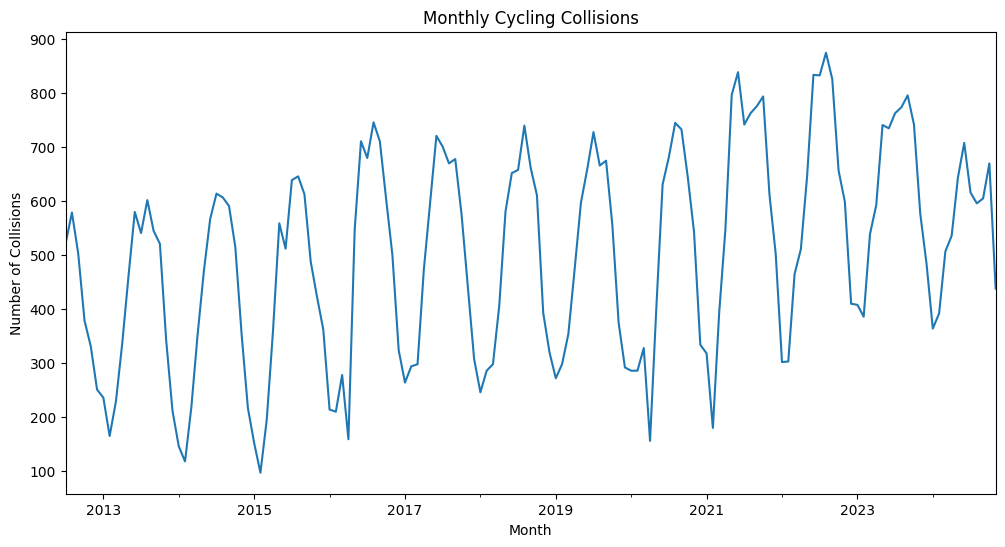

In [14]:
plot_monthly_collisions(bike_collision_df)

<Axes: xlabel='Crash_DateTime', ylabel='Count'>

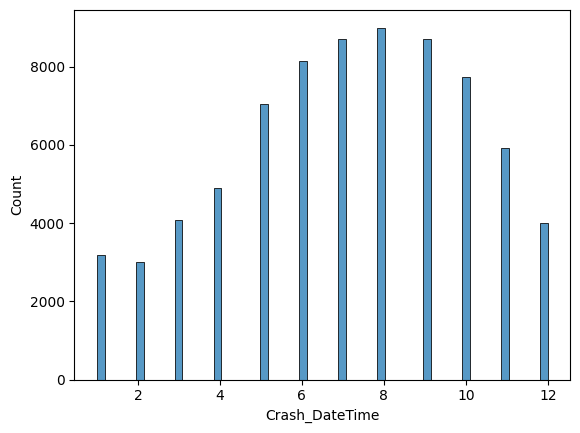

In [15]:
sns.histplot(bike_collision_df['Crash_DateTime'].dt.month)

There is a clear monthly pattern, with the most frequent accidents in the summer and fall months (likely due to increased use of the bicycle as a transport option). There also seems to be a slight trend in increasing accident numbers across the years. 

### Weekly patterns

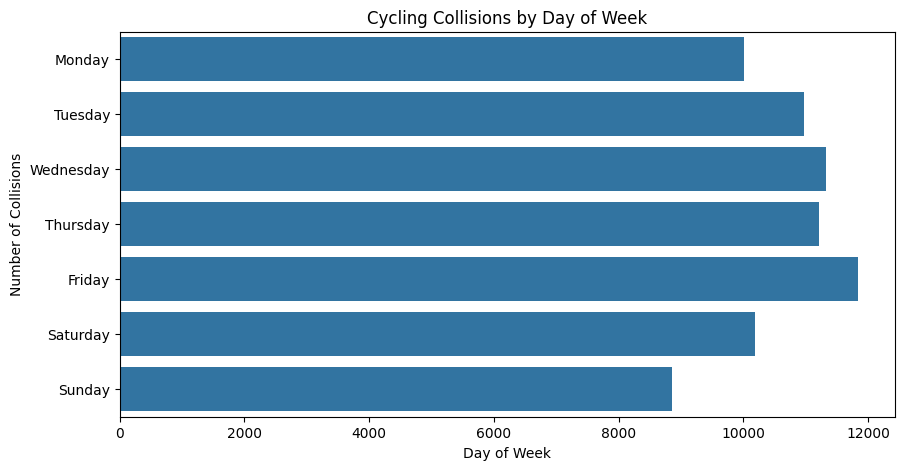

In [16]:
plot_collisions_by_day_of_week(bike_collision_df)

In [17]:
bike_collision_df.loc[:,'DayOfWeek'] = pd.Categorical(bike_collision_df['Crash_DateTime'].dt.day_name(), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
bike_collision_df.loc[:,'Month'] = pd.Categorical(bike_collision_df['Crash_DateTime'].dt.strftime('%b'), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

<Axes: xlabel='Month', ylabel='DayOfWeek'>

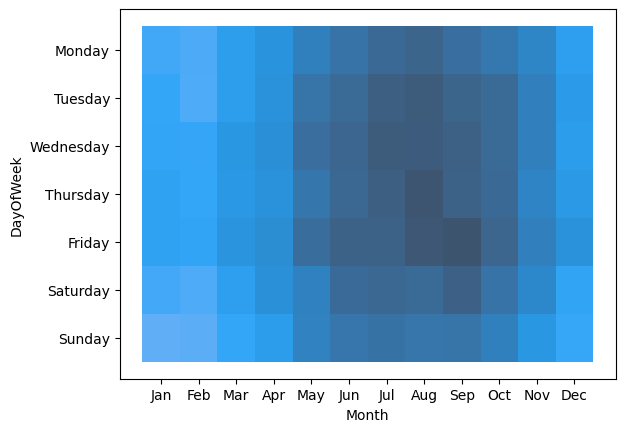

In [18]:
sns.histplot(bike_collision_df, x='Month', y='DayOfWeek')

### Intra-day patterns

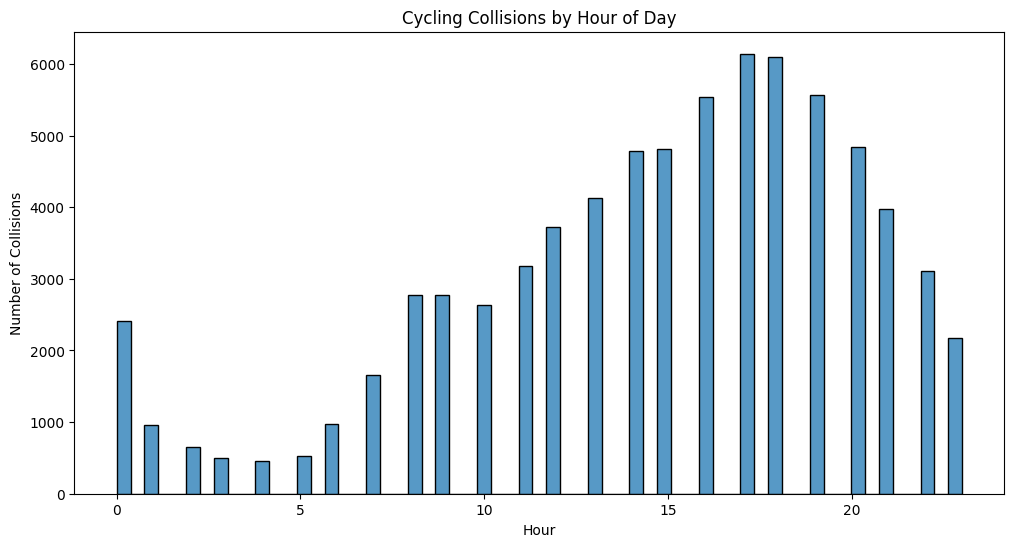

In [19]:
plot_collisions_by_hour(bike_collision_df)

In [20]:
bike_collision_df.loc[:, 'Hour'] = bike_collision_df['Crash_DateTime'].dt.hour

<Figure size 1200x1200 with 0 Axes>

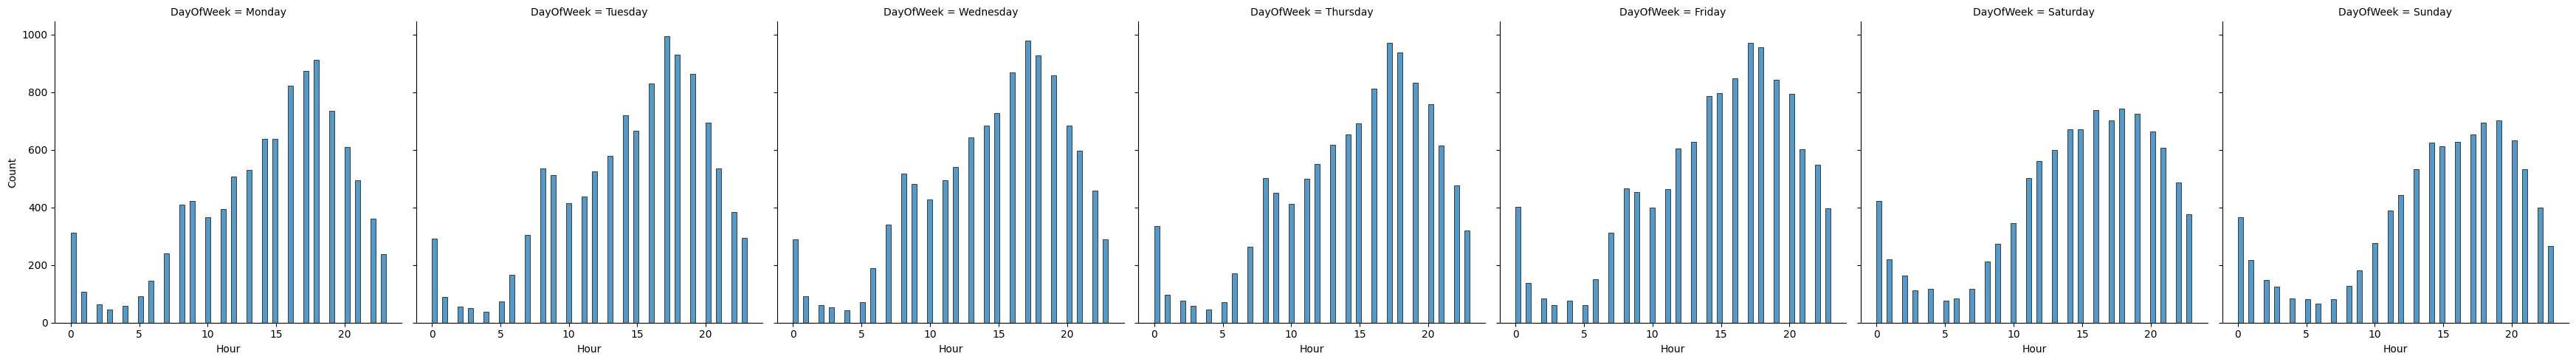

In [21]:
plt.figure(figsize=(12, 12))
sns.displot(bike_collision_df, x='Hour', col='DayOfWeek')

In [22]:
m = create_collision_heatmap(bike_collision_df)
m

# Create a spatio-temporal risk model

We want to predict the likelihood or risk of accident given a specific location and time of day. However, as the accident data, being on single event level, is only point data. To derive an accident occurence likelihood we could theoretically estimate across time and location, however the roughly 80k samples are very unlikely to carry enough information to be discrepant across time and location. In addition the dataset currently only contains positive examples, i.e. only accidents that have happened and not events that were not accidents. By sampling the accidents onto a spatial grid, we can ensure that (i) artificial negative examples can be created and (ii) we reduce resolution across space, but increase resolution across time (as per grid cell there will be more positive examples available).

Finally, to increase predictive power we include historical weather data, as weather may hold  explanatory value for accidents.

In [23]:
def create_spatial_grid(cycling_collisions: pd.DataFrame) -> pd.DataFrame:
    """
    Create a spatial grid for the collision data.
    """
    grid_size = 0.001 # in degrees, equates to roughly 110m
    cycling_collisions['Lat_grid'] = (cycling_collisions['LATITUDE'] // grid_size) * grid_size + grid_size / 2
    cycling_collisions['Lon_grid'] = (cycling_collisions['LONGITUDE'] // grid_size) * grid_size + grid_size / 2
    return cycling_collisions
    
def create_grid_neg_samples(accident_counts: pd.DataFrame, sample_size: int=200_000, random_state=SEED) -> pd.DataFrame:
    """
    Create a full grid covering the area defined by min and max latitudes and longitudes,
    and a sample of times in the range of the data.
    """
    # Get min and max latitude and longitude
    min_lat = accident_counts['LATITUDE'].min()
    max_lat = accident_counts['LATITUDE'].max()
    min_lon = accident_counts['LONGITUDE'].min()
    max_lon = accident_counts['LONGITUDE'].max()

    # Define grid size
    grid_size = 0.001  # Adjust grid size as needed

    # Create lists of latitudes and longitudes
    lat_range = np.arange(min_lat, max_lat + grid_size, grid_size)
    lon_range = np.arange(min_lon, max_lon + grid_size, grid_size)

    # Create a meshgrid of latitudes and longitudes
    lat_grid, lon_grid = np.meshgrid(lat_range, lon_range)

    # Flatten the grid arrays
    lat_grid_flat = lat_grid.flatten()
    lon_grid_flat = lon_grid.flatten()

    # Create a DataFrame for the full spatial grid
    spatial_grid = pd.DataFrame({
        'Lat_grid': lat_grid_flat,
        'Lon_grid': lon_grid_flat
    })

    # Get all unique combinations of Year, Month, Day, and Hour from accident_counts
    time_range = pd.DataFrame(pd.date_range(
        accident_counts['Crash_DateTime'].min().round('1h'),
        accident_counts['Crash_DateTime'].max().round('1h'),
        freq = '1h'
    ), columns=['Crash_DateTime'])

    # Sample to save memory
    time_range = time_range.sample(n=sample_size, replace=True, random_state=random_state).reset_index(drop=True)
    spatial_grid = spatial_grid.sample(n=sample_size, replace=True, random_state=random_state).reset_index(drop=True)

    return pd.concat([time_range, spatial_grid], axis=1)

def merge_with_grid(grid: pd.DataFrame, accident_counts: pd.DataFrame) -> pd.DataFrame:
    """
    Merge the accident counts with the full grid to include zero-accident cells.
    """
    # Merge accident_counts onto full_grid
    accident_counts_full = pd.concat([grid, accident_counts])

    # Fill missing Accident_Count with zero (no accidents in those grid cells)
    accident_counts_full['Accident_Count'] = accident_counts_full['Accident_Count'].fillna(0)

    return accident_counts_full


def identify_holidays(crash_datetimes: pd.Series) -> pd.Series:
    """
    Identify if a date is a holiday.
    """
    us_holidays = holidays.US()
    return crash_datetimes.dt.date.apply(lambda x: 1 if x in us_holidays else 0)
    
def extract_time_features(cycling_collisions: pd.DataFrame, dt_colname: str = 'Crash_DateTime') -> pd.DataFrame:
    """
    Extract time-related features from the collision data.
    """
    cycling_collisions['day'] = cycling_collisions[dt_colname].dt.day
    cycling_collisions['month'] = cycling_collisions[dt_colname].dt.month
    cycling_collisions['year'] = cycling_collisions[dt_colname].dt.year
    cycling_collisions['hour'] = cycling_collisions[dt_colname].dt.hour
    cycling_collisions['minute'] = cycling_collisions[dt_colname].dt.minute
    cycling_collisions['second'] = cycling_collisions[dt_colname].dt.second
    cycling_collisions['week'] = cycling_collisions[dt_colname].dt.isocalendar().week
    cycling_collisions['weekday'] = cycling_collisions[dt_colname].dt.weekday
    cycling_collisions['closest_hour'] = cycling_collisions[dt_colname].dt.round('1h')
    cycling_collisions['day_of_year'] = cycling_collisions[dt_colname].dt.dayofyear
    cycling_collisions['holiday'] = identify_holidays(cycling_collisions[dt_colname])

    cycling_collisions['working_day'] = (~cycling_collisions['holiday']) & (cycling_collisions['weekday'] < 6)
    cycling_collisions['rushhour'] = ((cycling_collisions['hour'] > 7) & (cycling_collisions['hour'] < 9)) | ((cycling_collisions['hour'] > 16) & (cycling_collisions['hour'] < 19))

    return cycling_collisions

def aggregate_accident_counts(cycling_collisions: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate accident counts by grid cell and time.
    """
    accident_counts = cycling_collisions.groupby(
        ['Lat_grid', 'Lon_grid', 'Crash_DateTime']).size().reset_index(name='Accident_Count')
    return accident_counts


def prepare_spatiotemporal_data(cycling_collisions: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare spatiotemporal data by creating grid cells and extracting time features.
    """
    cycling_collisions.reset_index(drop=True, inplace=True)
    cycling_collisions = cycling_collisions.dropna(subset=['LATITUDE', 'LONGITUDE'])
    neg_grid = create_grid_neg_samples(cycling_collisions)
    cycling_collisions = create_spatial_grid(cycling_collisions)
    cycling_collisions = aggregate_accident_counts(cycling_collisions)
    cycling_collisions = merge_with_grid(neg_grid, cycling_collisions)
    accident_counts = extract_time_features(cycling_collisions)
    return accident_counts


In [24]:
accidents = prepare_spatiotemporal_data(bike_collision_df)

In [25]:
def attach_weather_data(input_df):
    weather_df = pl.read_csv('data/open-meteo-40.74N74.04W51m(3).csv', try_parse_dates=True, null_values = 'NaN').with_columns(time=pl.col('time').dt.cast_time_unit('ns'))
    return input_df.join(weather_df, left_on='closest_hour', right_on='time', how='left').drop('closest_hour')

In [26]:
accidents = attach_weather_data(pl.DataFrame(accidents)).to_pandas()

In [27]:

def create_weather_interaction_terms(merged_data: pd.DataFrame) -> pd.DataFrame:
    """
    Create interaction terms between weather variables.
    """
    weather_features = [
        'temperature_2m_C',
        'relative_humidity_2m_perc',
        'precipitation_mm',
        'wind_speed_10m_km_h',
        'pressure_msl_hPa',
        'cloud_cover_perc',
    ]
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    weather_poly = poly.fit_transform(merged_data[weather_features])
    weather_poly_features = poly.get_feature_names_out(weather_features)
    weather_poly_df = pd.DataFrame(weather_poly, columns=weather_poly_features)
    merged_data.reset_index(drop=True, inplace=True)
    merged_data = pd.concat([merged_data, weather_poly_df], axis=1)
    return merged_data

def prepare_features(merged_data: pd.DataFrame):
    """
    Prepare the feature matrix.
    """
    weather_poly_features = [col for col in merged_data.columns if '^' in col or ':' in col]
   # weather_one_hot_features = [col for col in merged_data.columns if ]
    feature_columns = ['Lat_grid', 'Lon_grid', 'hour_sin', 'hour_cos', 'holiday'] + \
                      list(merged_data.filter(regex='DayOfWeek_').columns) + \
                      list(merged_data.filter(regex='Month_').columns) + \
                      ['temperature_2m_C', 'relative_humidity_2m_perc', 'precipitation_mm',
                       'wind_speed_10m_km_h', 'pressure_msl_hPa', 'cloud_cover_perc', 'is_day'] + \
                      weather_poly_features
    return merged_data[feature_columns]

def prepare_features_and_target(merged_data: pd.DataFrame):
    """
    Prepare the feature matrix and target vector.
    """
    X = prepare_features(merged_data)
    y = merged_data['Accident_Count']
    y_binary = (y >= 1).astype(int)
    return X, y_binary
    
def feature_engineering(merged_data: pd.DataFrame):
    """
    Perform feature engineering on the merged data.
    """
    merged_data = create_cyclic_time_features(merged_data)
    merged_data, scaler = normalize_weather_features(merged_data)
    #merged_data = create_weather_interaction_terms(merged_data)
    X, y_binary = prepare_features_and_target(merged_data)
    print(X.shape)
    return X, y_binary, scaler

In [28]:
X, y_binary, scaler = feature_engineering(accidents)

(274308, 12)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=SEED, stratify=y_binary)

# Base Model

In [30]:
# train base model without default hyperparameters 
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=SEED,
    verbosity=2,
)

clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=2024, ...)

## Model Evaluation

In [31]:
def plot_confusion_matrix(y_test: pd.Series, y_pred: np.ndarray):
    """
    Plot the confusion matrix.
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - XGBoost')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_roc_curve(y_test: pd.Series, y_proba: np.ndarray):
    """
    Plot the ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for XGBoost')
    plt.legend()
    plt.show()

def plot_precision_recall_curve(y_test: pd.Series, y_proba: np.ndarray):
    """
    Plot the Precision-Recall curve.
    """
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for XGBoost')
    plt.legend()
    plt.show()


def evaluate_model(best_model, X_test: pd.DataFrame, y_test: pd.Series):
    """
    Evaluate the trained model on the test set.
    """
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")
    plot_roc_curve(y_test, y_proba)
    plot_precision_recall_curve(y_test, y_proba)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     40000
           1       0.79      0.84      0.81     14862

    accuracy                           0.90     54862
   macro avg       0.86      0.88      0.87     54862
weighted avg       0.90      0.90      0.90     54862



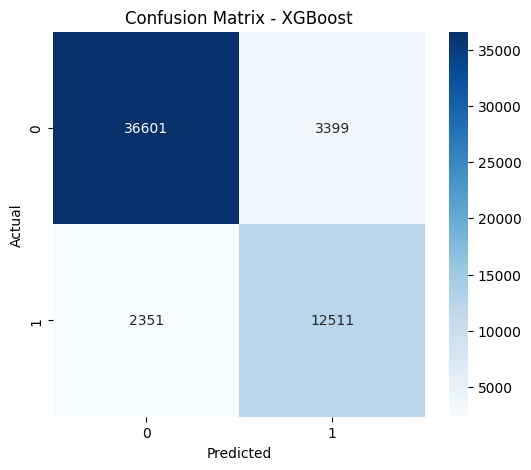

ROC AUC Score on Test Set: 0.9576


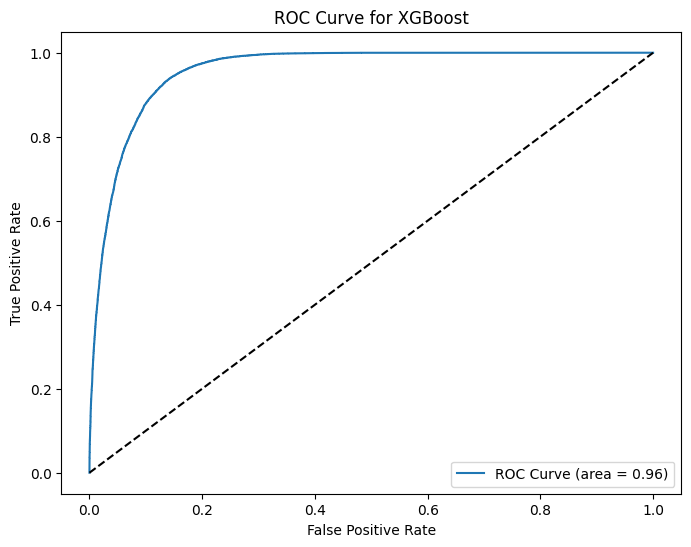

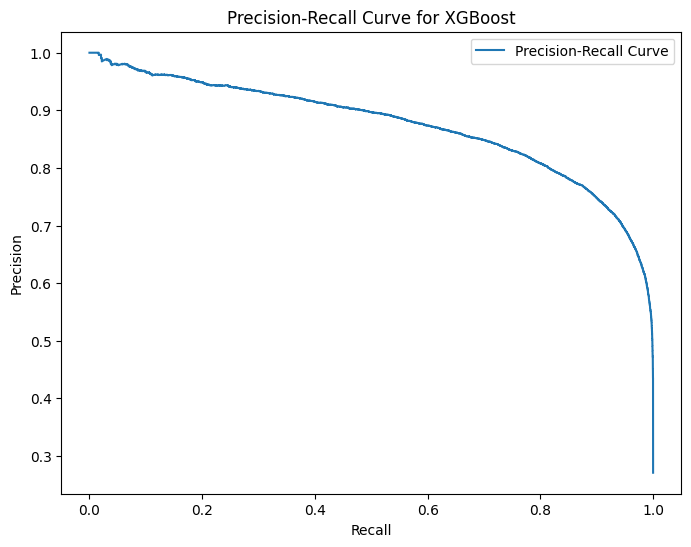

In [32]:
evaluate_model(clf, X_test, y_test)

# Hyperparameter Tuning

In [33]:
def model_training(X_train_res: pd.DataFrame, y_train_res: pd.Series):
    """
    Train the XGBoost model with hyperparameter tuning using RandomizedSearchCV.
    """
    xgb_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=SEED,
        #num_parallel_tree=3,
        verbosity=1,
    )
    
    param_dist = {
        'n_estimators': np.arange(50, 500, 25),
        'max_depth': np.arange(3, 12, 1),
        'learning_rate': np.linspace(0.01, 0.3, 10),
        'gamma': np.linspace(0, 0.5, 5),
        'reg_alpha': np.linspace(0, 1, 5),
        'reg_lambda': np.linspace(0, 1, 5)
    }
    
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=50,
        cv=cv_strategy,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=SEED,
        verbose=1,
        error_score='raise',
    )
    
    random_search.fit(X_train_res, y_train_res)
    best_model = random_search.best_estimator_
    
    print(f"Best parameters for XGBoost: {random_search.best_params_}")
    print(f"Best cross-validated ROC AUC for XGBoost: {random_search.best_score_:.4f}\n")
    return best_model

In [34]:
best_model = model_training(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid = os.fork()


Best parameters for XGBoost: {'reg_lambda': np.float64(0.25), 'reg_alpha': np.float64(0.75), 'n_estimators': np.int64(400), 'max_depth': np.int64(6), 'learning_rate': np.float64(0.1388888888888889), 'gamma': np.float64(0.0)}
Best cross-validated ROC AUC for XGBoost: 0.9594




Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     40000
           1       0.79      0.85      0.82     14862

    accuracy                           0.90     54862
   macro avg       0.87      0.88      0.87     54862
weighted avg       0.90      0.90      0.90     54862



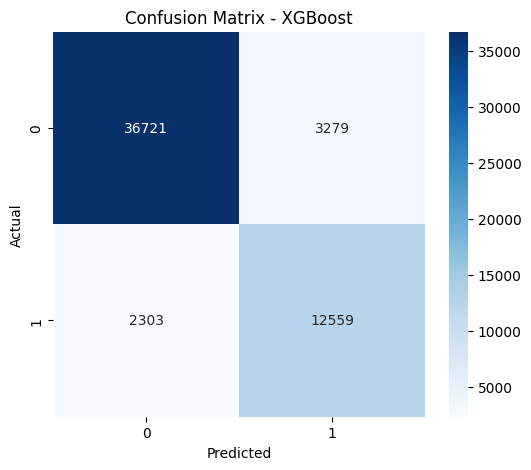

ROC AUC Score on Test Set: 0.9597


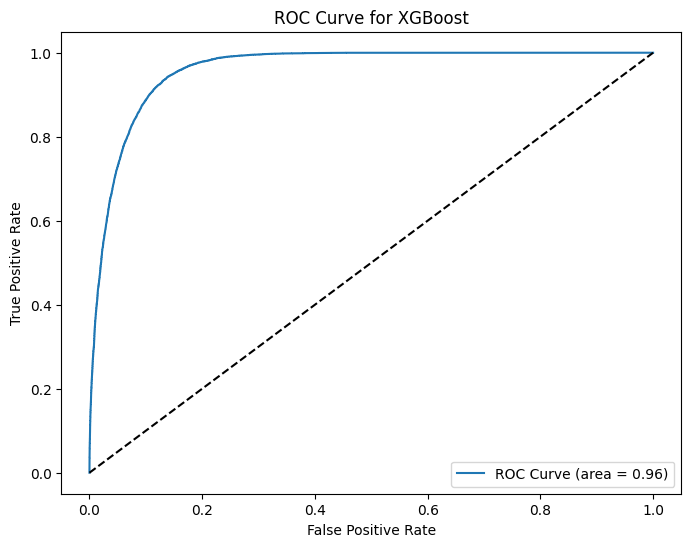

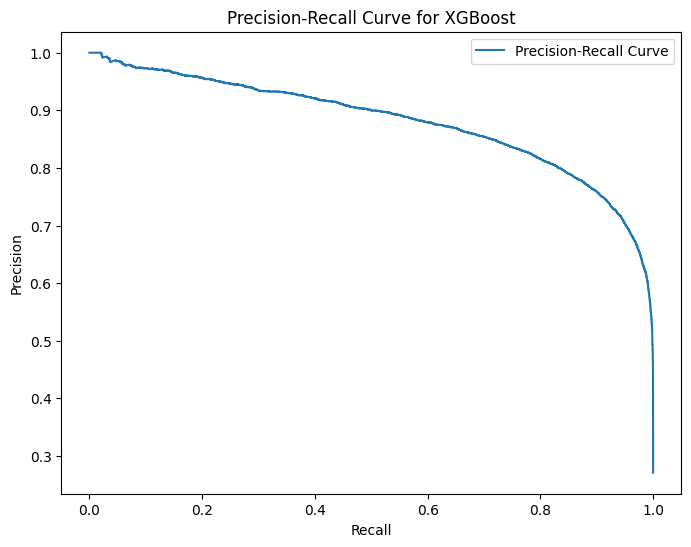

In [35]:
evaluate_model(best_model, X_test, y_test)

In [36]:
def plot_f1_score_vs_threshold(thresholds: np.ndarray, f1_scores: list):
    """
    Plot F1 Score versus classification threshold.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, f1_scores)
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Threshold')
    plt.show()

def adjust_threshold(best_model, X_test: pd.DataFrame, y_test: pd.Series):
    """
    Adjust the classification threshold to optimize F1 Score.
    """
    y_proba = best_model.predict_proba(X_test)[:, 1]
    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = [f1_score(y_test, (y_proba >= thresh).astype(int)) for thresh in thresholds]
    optimal_thresh = thresholds[np.argmax(f1_scores)]
    print(f"Optimal Threshold based on F1 Score: {optimal_thresh:.2f}")
    plot_f1_score_vs_threshold(thresholds, f1_scores)
    y_pred_optimal = (y_proba >= optimal_thresh).astype(int)
    print("\nClassification Report with Optimal Threshold:")
    print(classification_report(y_test, y_pred_optimal))



Optimal Threshold based on F1 Score: 0.39


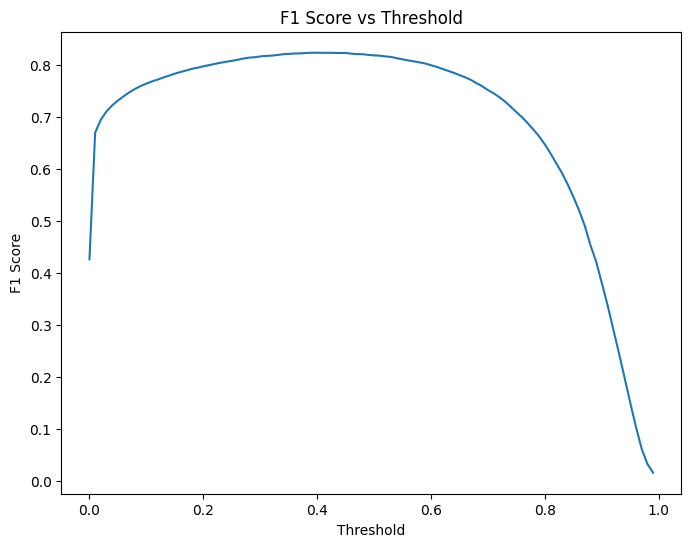


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93     40000
           1       0.76      0.90      0.82     14862

    accuracy                           0.90     54862
   macro avg       0.86      0.90      0.87     54862
weighted avg       0.91      0.90      0.90     54862



In [37]:
adjust_threshold(best_model, X_test, y_test)

In [38]:
def plot_feature_importance(model, X: pd.DataFrame):
    """
    Plot the feature importance from the XGBoost model.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X.columns
        feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        plt.figure(figsize=(12, 8))
        feature_importance.head(20).plot(kind='bar')
        plt.title('Top 20 Feature Importances from XGBoost')
        plt.xlabel('Features')
        plt.ylabel('Importance Score')
        plt.tight_layout()
        plt.show()
    else:
        print("The model does not provide feature importances.")

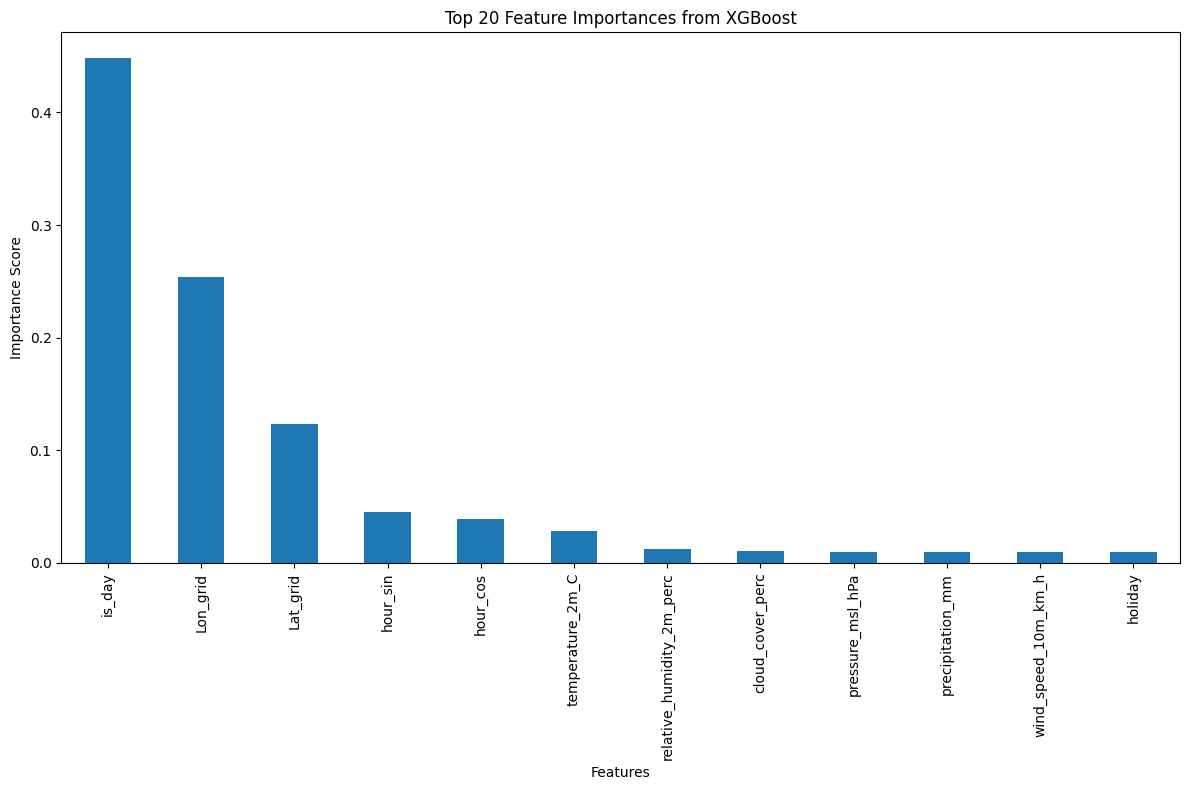

In [39]:
plot_feature_importance(best_model, X)

In [40]:
best_model.save_model('xgb_collision_prob_model.json')

### Key Observations for tuned model versus base model:
- Recall Improvement: The tuned model improves recall for class 1 (accidents) from 84% to 85%, meaning it identifies a greater proportion of actual accidents.
- F1 Score: increased slightly for accidens from 81% to 82%, showing better balance between precision and recall.
- Overall Accuracy remains constant at 90%, reflecting the stability of the model across both tuning stages.

### Verdict:

The hyperparameter-tuned XGBoost model demonstrates enhanced performance, achieving a balanced trade-off between precision and recall. It was optimized using RandomizedSearchCV, focusing on parameters like n_estimators, max_depth, learning_rate, gamma, reg_alpha, and reg_lambda.
Key Metrics:
- Precision (accidents): 79%
- Recall (accidents): 85%
- F1 Score (accidents): 82%
- Overall Accuracy: 90%

Best Hyperparameters:
- n_estimators: 400 (more boosting rounds capture intricate patterns)
- max_depth: 6 (balances model complexity and generalization)
- learning_rate: 0.138 (small updates ensure stability and better convergence)
- gamma: 0.0 (no additional penalties for splits)
- reg_alpha (L1 regularization): 0.75 (promotes sparsity, reducing overfitting)
- reg_lambda (L2 regularization): 0.25 (relaxes weight penalties, enhancing feature interactions)

## Predict unseen data

In [41]:
def predict_accident_likelihood(model, scaler, data: pd.DataFrame):
    """
    Predicts the likelihood of an accident for unseen data.
    """
    data = extract_time_features(data, dt_colname='Event_DateTime')
    
    data = attach_weather_data(pl.DataFrame(data)).to_pandas()

    data = create_cyclic_time_features(data)
    
    data, _ = normalize_weather_features(data)

    data = prepare_features(data)

    return model.predict_proba(data)


Test the model with artifical new data:
- Low risk location (central park) 40.77382668706782, -73.97100985361853, 1AM
- High risk location (6th/23rd) 40.74313803552326, -73.99326238759332, 8AM

In [42]:
new_data = pd.DataFrame({
    'Lat_grid': [40.77382668706782, 40.74313803552326],
    'Lon_grid': [-73.97100985361853, -73.99326238759332],
    'Event_DateTime': pd.to_datetime(['2024-10-01 01:00:00', '2024-08-01 08:00:00']),
})

In [43]:
predict_accident_likelihood(best_model, scaler, new_data)

array([[0.8401507 , 0.15984929],
       [0.10323548, 0.8967645 ]], dtype=float32)